# Transit fitting

*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

In [29]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
import exoplanet as xo

import pymc3 as pm
import pymc3_ext as pmx

import arviz as az
import corner

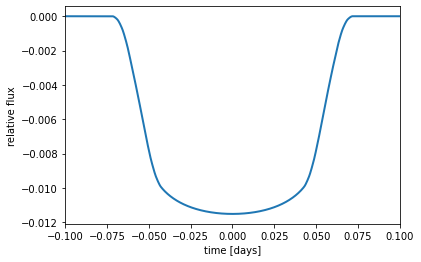

In [21]:
# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.1, t=t, texp=0.02)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

But the real power comes from the fact that this is defined as a [Theano operation](https://aesara.readthedocs.io/en/latest/extending/index.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.


## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [23]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

In [34]:
t

array([0.000e+00, 2.000e-02, 4.000e-02, ..., 7.994e+01, 7.996e+01,
       7.998e+01])

In [33]:
print(np.log(periods))
print(t0s)
print(t.shape)

[2.73741726 2.2291635 ]
[3.50418297 5.12286647]
(4000,)


Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009).
This reparameterizations is implemented in *exoplanet* as custom *PyMC3* distribution :class:`exoplanet.distributions.QuadLimbDark`.

In [35]:
with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    # planet Radius in units of R*
    r = pm.Uniform(
        "r", lower=0.01, upper=0.1, shape=2, testval=np.array([0.04, 0.06])
    )
    # impact parameter of the orbit
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=2, testval=np.random.rand(2)
    )

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # ******************************************************************* #
    # On the folowing lines, we simulate the dataset that we will fit     #
    #                                                                     #
    # NOTE: if you are fitting real data, you shouldn't include this line #
    #       because you already have data!                                #
    # ******************************************************************* #
    y = pmx.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    # ******************************************************************* #
    # End of fake data creation; you want to include the following lines  #
    # ******************************************************************* #

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = pmx.optimize(start=model.test_point)

KeyboardInterrupt: 

Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

In [25]:
map_soln

{'mean': array(3.87784842e-06),
 't0': array([3.50379146, 5.12178928]),
 'logP': array([2.737285  , 2.22916291]),
 'u_quadlimbdark__': array([-0.32984569, -0.41318161]),
 'r_interval__': array([-0.01481093,  0.17082213]),
 'b_impact__': array([ 3.09923304, -0.43746572]),
 'period': array([15.44499498,  9.29208447]),
 'u': array([0.5150018 , 0.13174249]),
 'r': array([0.05466676, 0.05883418]),
 'b': array([1.00916959, 0.4154283 ]),
 'light_curves': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])}

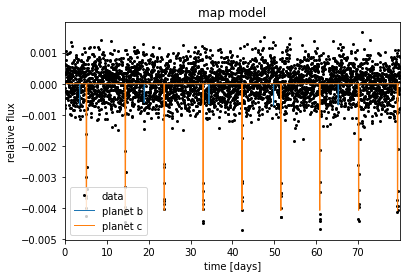

In [10]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use `pmx.sample` from [pymc3-ext](https://github.com/exoplanet-dev/pymc3-ext).

In [26]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        cores=2,
        chains=2,
        target_accept=0.9,
    )

/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/pymc3_ext/sampling/sampling.py:97: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, r, u, logP, t0, mean]


Sampling 2 chains for 3_000 tune and 3_000 draw iterations (6_000 + 6_000 draws total) took 5785 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [30]:
with model:
    summary = az.summary(
        trace, var_names=["period", "t0", "r", "b", "u", "mean"]
    )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
period[0],16.298,1.599,12.982,18.022,0.720,0.543,6.0,18.0,1.32
period[1],9.292,0.000,9.291,9.293,0.000,0.000,34.0,111.0,1.08
t0[0],3.135,0.893,0.998,4.397,0.253,0.183,17.0,20.0,1.33
t0[1],5.122,0.002,5.119,5.126,0.000,0.000,35.0,140.0,1.10
r[0],0.034,0.026,0.010,0.088,0.006,0.004,24.0,77.0,1.07
r[1],0.058,0.001,0.057,0.060,0.000,0.000,73.0,180.0,1.02
b[0],0.764,0.302,0.165,1.095,0.048,0.039,24.0,84.0,1.07
b[1],0.390,0.040,0.317,0.468,0.005,0.004,58.0,124.0,1.05
u[0],0.441,0.200,0.046,0.786,0.021,0.015,89.0,147.0,1.02
u[1],0.297,0.300,-0.270,0.816,0.036,0.025,73.0,117.0,1.02


That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

/Users/jorgemarpa/.pyenv/versions/adap/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


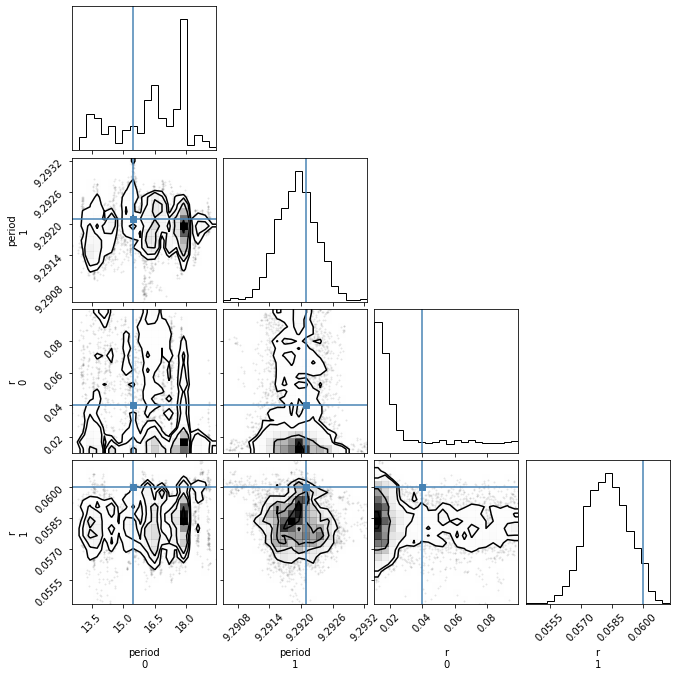

In [31]:
truth = dict(
    zip(
        ["period", "r"],
        pmx.eval_in_model([period, r], model.test_point, model=model),
    )
)
_ = corner.corner(
    trace,
    var_names=["period", "r"],
    truths=truth,
)

## Phase plots

Like in the [Radial velocity fitting](./rv.ipynb) tutorial, we can make plots of the model predictions for each planet.

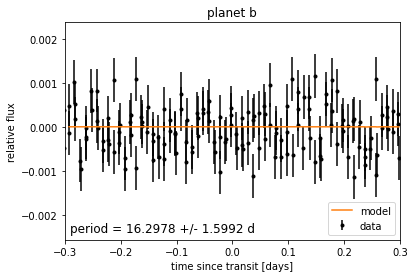

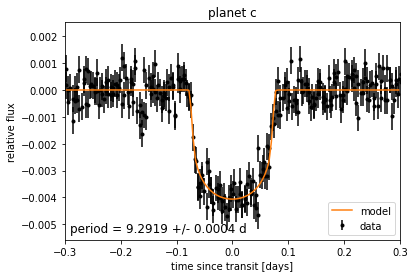

In [32]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.errorbar(
        x_fold, y - other, yerr=yerr, fmt=".k", label="data", zorder=-1000
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n])
    )
    plt.annotate(
        txt,
        (0, 0),
        xycoords="axes fraction",
        xytext=(5, 5),
        textcoords="offset points",
        ha="left",
        va="bottom",
        fontsize=12,
    )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter))
    plt.xlim(-0.3, 0.3)

## Citations

As described in the [Citing exoplanet & its dependencies](./citation.ipynb) tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [ ]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

print("\n".join(bib.splitlines()[:10]) + "\n...")